# Visualization / Creating Flood Mask

Below we are going to demonstrate the capability that we ran through docker

In [1]:
from os.path import join
from os.path import abspath, basename, dirname, isabs, isfile

import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rxr
import xarray as xr

from hydromt_sfincs import SfincsModel, utils

### Step 0: Run imports and define model

In [2]:
sfincs_root = "/app/data/SFINCS/ngwpc_data"
mod = SfincsModel(sfincs_root, mode="r")

In [3]:
import xarray as xr
ds = xr.open_dataset("/app/data/SFINCS/ngwpc_data/sfincs_map.nc", engine="netcdf4")
ds

<xarray.Dataset> Size: 338MB
Dimensions:        (n: 938, m: 221, corner_n: 939, corner_m: 222, time: 193,
                    timemax: 8, runtime: 1)
Coordinates:
    x              (n, m) float32 829kB ...
    y              (n, m) float32 829kB ...
  * time           (time) datetime64[ns] 2kB 2019-05-20 ... 2019-05-28
  * timemax        (timemax) datetime64[ns] 64B 2019-05-21 ... 2019-05-28
Dimensions without coordinates: n, m, corner_n, corner_m, runtime
Data variables: (12/13)
    inp            int32 4B ...
    corner_x       (corner_n, corner_m) float32 834kB ...
    corner_y       (corner_n, corner_m) float32 834kB ...
    crs            int32 4B ...
    sfincsgrid     int32 4B ...
    msk            (n, m) float32 829kB ...
    ...             ...
    zs             (time, n, m) float32 160MB ...
    h              (time, n, m) float32 160MB ...
    zsmax          (timemax, n, m) float32 7MB ...
    hmax           (timemax, n, m) float32 7MB ...
    total_runtime  (runtime) float32 4B ...
    average_dt     (runtime) float32 4B ...
Attributes:
    Conventions:                         Conventions = 'CF-1.6, SGRID-0.3
    Build-Revision-Date-Netcdf-library:  4.8.1 of Sep 29 2021 09:36:14 $
    Producer:                            SFINCS model: Super-Fast INundation ...
    Build-Revision:                      $Rev: v2.0.3-Cauberg
    Build-Date:                          $Date: 2023-11-15
    title:                               SFINCS map netcdf output

** NOTE the step below needs to be run twice if there is an error

In [5]:
fn_map="sfincs_map.nc"
if not isabs(fn_map):
    fn_map = join(mod.root, fn_map)
if isfile(fn_map):
    ds_face, ds_edge = utils.read_sfincs_map_results(
        fn_map,
        ds_like=mod.grid,
        drop=["crs", "sfincsgrid"],
        logger=mod.logger,
    )
mod.set_results(ds_face, split_dataset=True)
mod.set_results(ds_edge, split_dataset=True)

### Step 1: Plot maximum flooding extent 

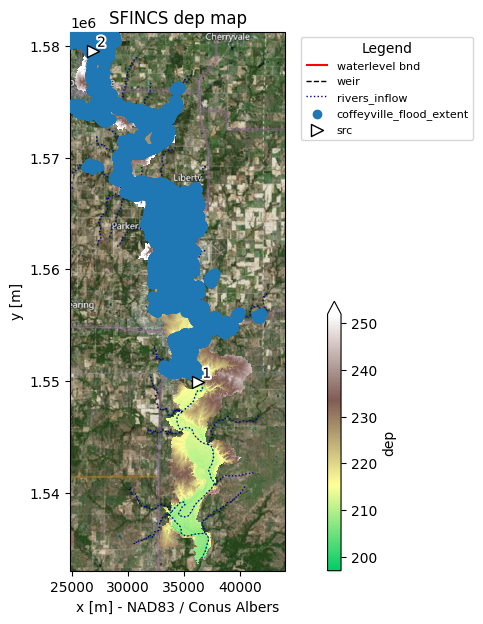

In [6]:
fig, ax = mod.plot_basemap(fn_out=None, bmap="sat", figsize=(11, 7))

In [7]:
mod.write_raster("results.hmax", compress="LZW")

### Step 2: Create Flood mask

We need to take this tiff file and make a binary flood mask

In [8]:
output_tif = "/app/data/SFINCS/ngwpc_data/gis/output_binary_sfincs.tif"
input_tif = "/app/data/SFINCS/ngwpc_data/gis/hmax.tif"
with rxr.open_rasterio(input_tif) as rds:
    rds_wgs84 = rds.rio.reproject("EPSG:4326", from_crs="EPSG:5070") 
    
    # Get the nodata value
    nodata = rds.rio.nodata
    
    # Convert to binary
    if nodata is not None:
        # Create a mask for valid data (non-nodata values)
        valid_data_mask = rds_wgs84 != nodata
        # Initialize binary data with 255 (new nodata value for uint8)
        binary_data = np.full_like(rds_wgs84, 255, dtype=np.uint8)
        # Set 0 for negative values and 1 for positive values, only where data is valid
        binary_data = np.where(np.logical_and(rds_wgs84 <= 0, valid_data_mask), 0, binary_data)
        binary_data = np.where(np.logical_and(rds_wgs84 > 0, valid_data_mask), 1, binary_data)
    else:
        # If there's no nodata value, simply convert based on sign
        binary_data = (rds_wgs84 > 0).astype(np.uint8)
    
    # Create a new DataArray with the binary data
    binary_rds = rds_wgs84.copy(data=binary_data)
    
    # Set the nodata value to 255
    binary_rds.rio.write_nodata(255, inplace=True)
    
    # Write to file
    binary_rds.rio.to_raster(output_tif, dtype="uint8")

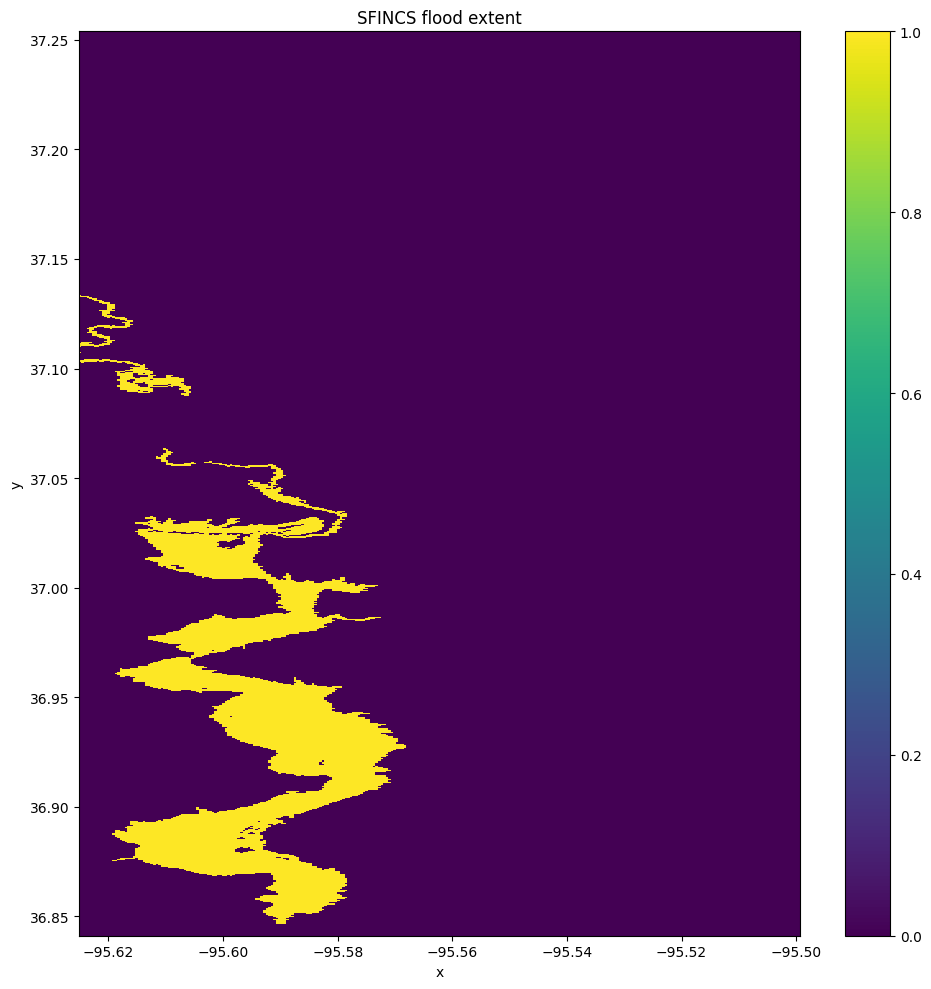

In [9]:
import rioxarray as rxr
import geopandas as gpd

raster = rxr.open_rasterio(output_tif)

if raster.shape[0] > 1:
    raster = raster[0]

# Set the no-data value
raster = raster.where(raster != 255)
raster = raster.fillna(0)

# Plot the result
fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))

# Plot original raster
im1 = raster.plot(ax=ax1, cmap='viridis', vmin=0, vmax=1)
ax1.set_title('SFINCS flood extent')

plt.tight_layout()
plt.show()

Now that our mask has been created, we can evaluate how our model did